# Echosounder Data Processing Example

This notebook will demonstrate the basic steps to load and plot the data from the so-called "zooplankton sonar" (ZPLS) on the OOI network. However, the sonar can not only see zooplankton, but also fish. On the OOI website, they are also called "Bio-acoustic Sonar." Here we are going to call it **echosounder**, which is how this type of sonar is usually called in fisheries and marine ecological studies.

## Echosounders on the OOI network

To figure out what echosounders are available on the OOI network, let's first get to http://oceanobservatories.org/instrument-class/zpls/ for an overview:
![zpls_summary](../img/zpls_table.png)
<!-- <img src="../img/zpls_table.png", width=650> -->

We can see that there are two types of echosounders: Modified EK60 from Kongsberg and AZFP from ASL Environmental Sciences. There are only 2 EK60's on the OOI network, located on the Cabled Endurance nodes (I am not sure if this is the right name... but we'll use it anyway). All other uncabled nodes have the AZFP echosounders.

Just to put things more into perspective, below you can see where the cabled and uncabled nodes are in the Endurance Array.
![Endurance echosounder locations](../img/endurance_echosounder.png)
<!-- <img src="../img/endurance_echosounder.png", width=300> -->
In this demo we will use data from the upward-looking EK60 echosounder on the 200m platform at the Endurance Offshore Site (EAO, or Oregon Offshore Cabled Shallow Profiler Mooring). It is the red blob on the left in the map. You can find out more about this platform at http://oceanobservatories.org/site/ce04osps/

Before we start, let's first load some modules we will need for this demo notebook.

In [1]:
import glob, h5py, os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
import sys
sys.path.insert(0,'../')
from unpack_ek60 import raw2hdf5_initiate, raw2hdf5_concat

/Users/wu-jung/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Unpacking EK60 data

The first thing we need to do to process data from the echosounders is to unpack the data, from binary to something more accessible, such as HDF5. To do this, in the tutorial folder are some tools that can be imported as modules from the local directory. The tools were created based on the unpacking code in this repo: https://github.com/oceanobservatories/mi-instrument/tree/master/mi/instrument/kut/ek60/ooicore  I added compensation for transmission loss and calilbration stuff and wrap things around in a class to streamline the process.

There are more to be done to further develop this module. One immediate goal is to include parsing and processing AFZP (ZPLSC_C and ZPLSG_A in the table above) into this so that similar operations and plotting can be done on other OOI echosounder data sets. I dug around and found some unpacking pieces also from the oceanobservatories repo here that seem useful: https://github.com/oceanobservatories/mi-instrument/tree/0a9ace91f866ee7529685e65a7000f9a7f2f580a/mi/dataset/parser

## Can the echosounders tell us how animals respond to eclipse?

Let's now try to unpack the echosounder data collected on August 21, 2017.

Does this sound like an important day? Maybe? :)

That was the day with all the hypes last year - when the eclipse happened and people across the US got to see it. In fact, the EAO site was right in the totality zone, so by looking at the echosounder data we may be able to see how the animals respond to the unusual change of solar radiation level, which we also have data for thanks to the OOI infrastructure!

So, how do the animals respond to eclipse? To answer this question, we need not only echosounder data, but also solar radiation data. In this demo we will do both and plot them together!

In [2]:
files = glob.glob('../data_zplsc/OOI-D2017082[1,2]*.raw')
h5_fname = '../data_zplsc/EAO-D20170821-22.h5'

In [3]:
raw2hdf5_initiate(files[0],h5_fname) # unpack 1st file and create HDF5 file
for fname in files[1:]:
    raw2hdf5_concat(fname,h5_fname)  # unpack other files and append to HDF5

23:50:09  unpacking file: ../data_zplsc/OOI-D20170821-T000000.raw
23:50:13  unpacking file: ../data_zplsc/OOI-D20170821-T013914.raw
23:50:17  unpacking file: ../data_zplsc/OOI-D20170821-T031816.raw
23:50:20  unpacking file: ../data_zplsc/OOI-D20170821-T045717.raw
23:50:24  unpacking file: ../data_zplsc/OOI-D20170821-T063618.raw
23:50:27  unpacking file: ../data_zplsc/OOI-D20170821-T081522.raw
23:50:30  unpacking file: ../data_zplsc/OOI-D20170821-T095435.raw
23:50:34  unpacking file: ../data_zplsc/OOI-D20170821-T113343.raw
23:50:37  unpacking file: ../data_zplsc/OOI-D20170821-T131245.raw
23:50:40  unpacking file: ../data_zplsc/OOI-D20170821-T145147.raw
23:50:44  unpacking file: ../data_zplsc/OOI-D20170821-T163049.raw
23:50:47  unpacking file: ../data_zplsc/OOI-D20170821-T180952.raw
23:50:51  unpacking file: ../data_zplsc/OOI-D20170821-T194853.raw
23:50:54  unpacking file: ../data_zplsc/OOI-D20170821-T212802.raw
23:50:57  unpacking file: ../data_zplsc/OOI-D20170821-T230706.raw
23:50:59  

Now we have the echosounder data stored as HDF5 for easy access.

The above can also be done through command line by calling `echopype_converter.py`. The usage is something like:

```
$ python echopype_converter.py -h
Convert EK60 *.raw to HDF5

optional arguments:
  -h, --help            show this help message and exit
  -o OUTPUT_FILE, --output-file OUTPUT_FILE
                        output HDF5 filename
  -i INPUT_FILE [INPUT_FILE ...], --input-file INPUT_FILE [INPUT_FILE ...]
                        input *.raw filename
```

## Cleaning and subsetting raw echo data

The next step is to clean up the raw data we just loaded and do some basic compensation of the transmission loss of sound due to propagation and absorption by seawater. The operations will be done by using methods from a python class `EchoDataRaw`. We will first create an instance of this class with the HDF5 file we just created.

In [4]:
import echopype_model

In [5]:
# create EchoDataRaw object for manipulation
edata = echopype_model.EchoDataRaw(h5_fname)
edata_clean = echopype_model.EchoDataRaw(h5_fname)

### Explore the data

The first thing for any processing is to estimate how much noise there is from either backgound or instruments, or both. There are a few _standard_ (as in convention of the field) ways to do it. I implemented the method proposed by De Robertis and Higginbottom (2007, ICES JMR) to do this.

This is a fairly expensive operation and I want to learn how this can be sped up by by distributed processing during the hackweek.

In [6]:
%%time
edata_clean.remove_noise()  # regular noise removal

../echopype_model.py:195: RuntimeWarning: invalid value encountered in log10
  tmp = 10*np.log10(np.ma.masked_less_equal(subtract,0))


CPU times: user 2min 39s, sys: 45.4 s, total: 3min 25s
Wall time: 3min 55s


We can explore what's in the data a little bit. The most important information in the echo data are the returning echo strengths and ping time (sonar transmission time).

Let's first check the ping time:

In [7]:
# Check ping time of the first 10 pings
num2date((edata_clean.ping_time[0:20],edata_clean.ping_time[-20:]))

[[datetime.datetime(2017, 8, 21, 0, 0, 0, 55059, tzinfo=<matplotlib.dates._UTC object at 0x10e086e10>),
  datetime.datetime(2017, 8, 21, 0, 0, 2, 64171, tzinfo=<matplotlib.dates._UTC object at 0x10e086e10>),
  datetime.datetime(2017, 8, 21, 0, 0, 3, 67223, tzinfo=<matplotlib.dates._UTC object at 0x10e086e10>),
  datetime.datetime(2017, 8, 21, 0, 0, 4, 70285, tzinfo=<matplotlib.dates._UTC object at 0x10e086e10>),
  datetime.datetime(2017, 8, 21, 0, 0, 5, 73338, tzinfo=<matplotlib.dates._UTC object at 0x10e086e10>),
  datetime.datetime(2017, 8, 21, 0, 0, 6, 76400, tzinfo=<matplotlib.dates._UTC object at 0x10e086e10>),
  datetime.datetime(2017, 8, 21, 0, 0, 7, 79452, tzinfo=<matplotlib.dates._UTC object at 0x10e086e10>),
  datetime.datetime(2017, 8, 21, 0, 0, 8, 81509, tzinfo=<matplotlib.dates._UTC object at 0x10e086e10>),
  datetime.datetime(2017, 8, 21, 0, 0, 9, 85567, tzinfo=<matplotlib.dates._UTC object at 0x10e086e10>),
  datetime.datetime(2017, 8, 21, 0, 0, 10, 88629, tzinfo=<matplo

We can see that the echosounder pinged every 1 second, almost 24/7, except for the last 5 mins before midnight. According to the engineering team, these 5 mins are needed for resetting the echosounder to collect data for the next day.

Next we can check the echo strengths data format from different frequencies:

In [8]:
# Check how echo strentghs are stored in the object
for d in edata_clean.Sv_corrected.items():
    print(d)

('120000.0', masked_array(
  data=[[4.379685010547615, 20.04265197243928, 20.019134004028036, ...,
         0.0, 0.0, 0.0],
        [9.624191966256141, 25.851590170017673, 25.851590170017673, ...,
         0.0, 0.0, 0.0],
        [9.600673997844893, 25.828072201606425, 25.8163132174008, ...,
         0.0, 0.0, 0.0],
        ...,
        [-68.68660758655386, -48.67680822196411, -49.21152904189705, ...,
         0.0, 0.0, 0.0],
        [-63.00514158321154, -45.00836832005358, -47.776400188533344,
         ..., 0.0, 0.0, 0.0],
        [-63.35932844486946, -43.416372004953445, -54.59982729691038,
         ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=

It's always easier to explore data if we can visualize that. So let's try to plot the **echogram** (here goes with the jargon!), basically color-coded echo strength arranged across multiple pings. We can get a good sense of how the data look like by plotting a small section of data from one frequency.

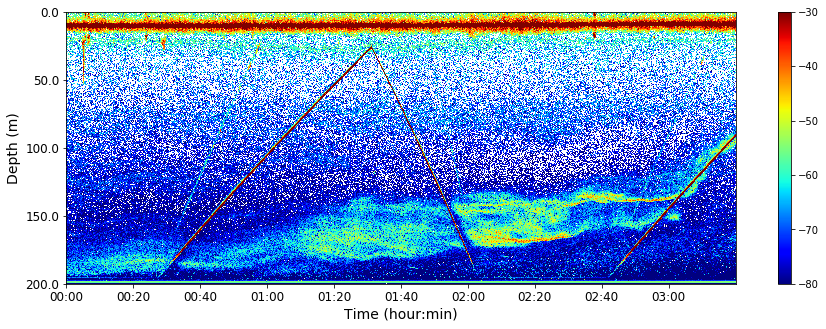

In [9]:
# Getting start and end depth indices
depth_max = 200
depth_min = 0
sz = edata_clean.Sv_corrected['200000.0'].shape      # size of one frequency of data
depth_vec = np.arange(sz[0])*edata_clean.bin_size    # list of depth bins [m]
depth_idx_start = np.searchsorted(depth_vec, depth_min, side="left")
depth_idx_end = np.searchsorted(depth_vec, depth_max, side="right")
if depth_idx_end>=depth_vec.shape[0]:
    depth_idx_end = depth_vec.shape[0]-1

# Getting depth label
depth_ticks_num = 5
y_ticks_spacing = sz[0]/(depth_ticks_num-1)
y_ticks = np.arange(depth_ticks_num)*y_ticks_spacing
depth_spacing = np.around((depth_max-depth_min)/(depth_ticks_num-1),decimals=1)
depth_label = np.around(np.arange(depth_ticks_num)*depth_spacing,decimals=1)
    
# Getting ping time label for first 1000 pings
num_ping_to_plot = 12000
num_ping_label = 10
x_ticks = np.int32(np.arange(0,num_ping_label)*num_ping_to_plot/num_ping_label)
x_ticks_label = [x.strftime('%H:%M') for x in num2date(edata_clean.ping_time[x_ticks])]

# Plot it!
fig = plt.figure(figsize=(15,5))
plt.imshow(edata_clean.Sv_corrected['200000.0'][::-1,0:num_ping_to_plot],aspect='auto',vmax=-30,vmin=-80,cmap='jet')
plt.xticks(x_ticks,x_ticks_label,fontsize=12)
plt.yticks(y_ticks,depth_label,fontsize=12)
plt.xlabel('Time (hour:min)',fontsize=14)
plt.ylabel('Depth (m)',fontsize=14)
plt.colorbar()
plt.show()

There is a lot of empty spots in the echograms (anything below the range-dependent esimated noise level). It's not visually super appealing, but gives us a good sense of how the data quality may be like. Later we will discuss how people go from this type of data (with many missing values) to biomass estimation briefly.

The cloud-like stuff on the echogram are echoes from animals in the water column. In addition we see dark red stripes going up and down the water column. These are echo returns from the shallow water profiler that is mounted on the same platform.

Note that the plotting code you just saw is actually under the hood stuff for the class method `EchoDataViewer.echogram()` which we will use in just a bit.

### Subsetting echo data

Now, the echosounder transmits sound every second for the whole day. It seems a bit unnecessary to try to plot out every single ping, since at the scale we are looking at (i.e., a day), things to the most part don't change that fast. Therefore, we can subset the data so that we only use 1 ping of data every 2 mins.

Note that I put in kwarg `hr_offset=7` because the observation was done in PDT, but the instrument was configured using UTC time.

In [10]:
%%time
date_wanted = [dt.date(2017,8,21).strftime('%Y%m%d')]
subset_params_names = ["hour_all","min_all","sec_all"]
subset_params_vals = (range(24),range(0,54,2),[0])  # note we only subset for 54 mins
subset_params = dict(zip(subset_params_names,subset_params_vals))
edata_clean.subset_data(date_wanted,subset_params,hr_offset=7)   # subset data

CPU times: user 12.3 s, sys: 21 s, total: 33.3 s
Wall time: 54.7 s


You see that we only request to subset up to the 52th min of each hour. This is because there is a gap of time right before midnight that the echosounder was reset for sampling the next day, so there's a gap of data during that time. Data from all other hours were continuous. But since it's more convenient to have uniform sonar transmit time for plotting, we set this subsetting routine for every hour.

Let's take a look at how the cleaned data looks like in an echogram. We will do this bia creating a EchoDataViewer class object, which was created to save repetitive manipulations of setting axis ticks and ticklabels.

In [11]:
import echopype_view

In [12]:
# Create viewer object and initialize with cleaned data
edata_clean_view = echopype_view.EchoDataViewer(edata_clean)

In [13]:
# Set date range to view in echogram
# note we do 20170821-20170822 as a range, even though we only plot for 1 day
date_range_to_view = [dt.date(2017,8,21),dt.date(2017,8,22)]
edata_clean_view.set_date_range(date_range_to_view)

In [14]:
# Set colormap to use
edata_clean_view.set_cmap('jet')

Under the hood there are a bunch of default plotting parameters, which we will use when calling `EchoDataViewer.echogram` to plot echograms.

In [15]:
echopype_view.ECHOGRAM_PARAMS

defaultdict(list,
            {'c_ticks_spacing': [],
             'cmap_max': -30,
             'cmap_min': -80,
             'depth_max': 200,
             'depth_min': 0,
             'depth_ticks_num': 5,
             'hour_spacing': 1})

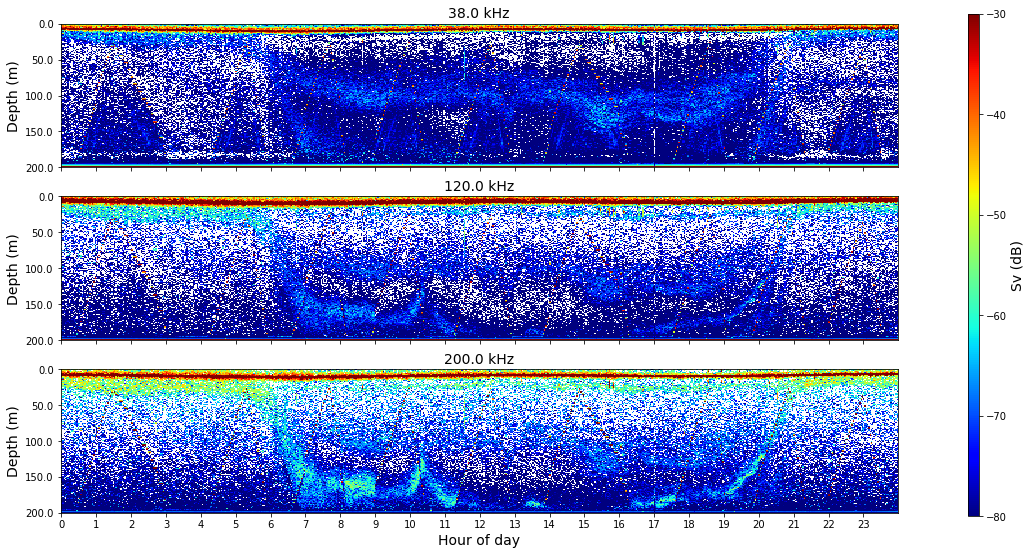

In [16]:
freq_to_plot = [38000,120000,200000]    # set frequencies to be plotted
num_freq = len(freq_to_plot)

fig,ax = plt.subplots(num_freq,1,sharex=True,figsize=(15,9))
for idx,freq in zip(range(num_freq),freq_to_plot):
    data_axes = edata_clean_view.echogram(ax[idx],echopype_view.ECHOGRAM_PARAMS,freq)
    ax[idx].set_ylabel('Depth (m)',fontsize = 14)
    ax[idx].set_title(str(freq/1000)+' kHz',fontsize = 14)
ax[num_freq-1].set_xlabel('Hour of day',fontsize = 14)
cax = fig.add_axes([0.965, 0.12, 0.01, 0.775])
cb = fig.colorbar(data_axes, cax=cax, use_gridspec=True)
cb.set_label('Sv (dB)',fontsize=14)
plt.show()

As you see, there is a lot of empty spots in the echograms (anything below the range-dependent esimated noise level), and it's kinda difficult to get a clear picture of what's going on. Normally when echo data are used to estimate biomass of marine organisms, these cleaned data will be further averaged into each small tiles to obtain the mean volume backscattering strength (MVBS). But let's not worry about that operation right now and just use all the data points.

Disclosure: the EchoDataRaw class actually has method `EchoDataRaw.get_mvbs()` and `EchoDataRaw.save_mvbs2hdf5()` to calculate and save MVBS results to HDF5 files. But corresponding reading and plotting functions are not complete yet...

### Maybe we get a better picture by not removing noise?

So in this second case, we will not remove any noise from the data just so that we can get better pictures (while knowing the caveats):

In [17]:
%%time
const_noise = 0
edata.remove_noise(const_noise)  # put in a dummy constant noise level

../echopype_model.py:186: RuntimeWarning: divide by zero encountered in log10
  Sv_noise[freq_str] = 10*np.log10(self.noise_est[freq_str])+TVG+ABS-CSv-Sac


CPU times: user 1min 2s, sys: 1min 27s, total: 2min 29s
Wall time: 3min 30s


In [18]:
# subset data using same parameters as before
edata.subset_data(date_wanted,subset_params,hr_offset=7)

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


Note that in the above, I put in a constant noise level (=0). This is just a dummy, because here I want to see how the data look like without taking out any points (i.e., treating everything as "data"). What's really important in `remove_noise` is that the transmission loss of sound is compensated for, even if I only put in a dummy for the noise level. If I call this method as: `edata.remove_noise()` without the dummy, the code will call `edata.get_noise()` to estimate the noise level, remove any data points that are below the estimated noise level, and compensate for the transmission loss.

Again let's take a look at how the echogram looks like:

In [19]:
# Create viewer object and initialize with noisy data
# Using the same routine as in Case 1
edata_view = echopype_view.EchoDataViewer(edata)
edata_view.set_date_range(date_range_to_view)
edata_view.set_cmap('jet')

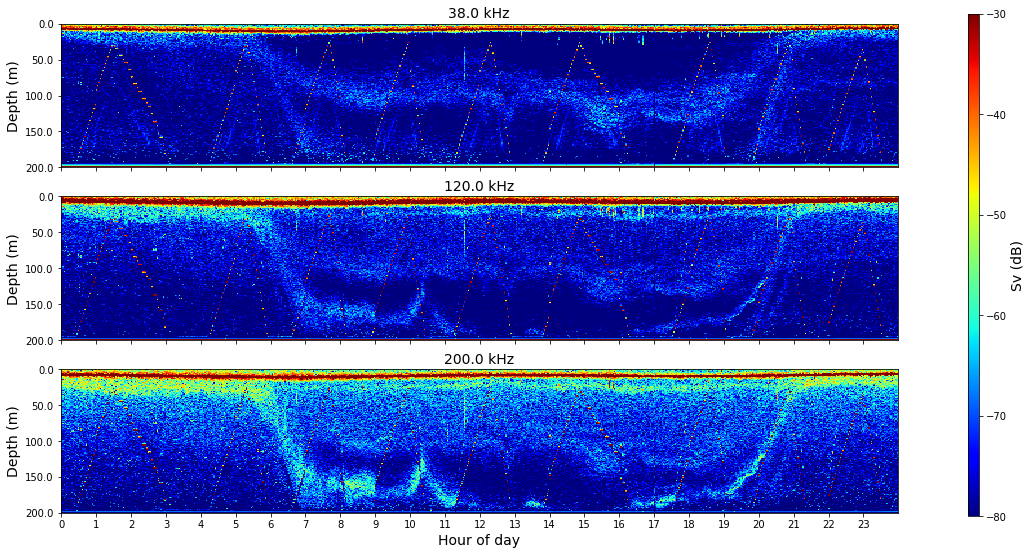

In [20]:
freq_to_plot = [38000,120000,200000]    # set frequencies to be plotted
num_freq = len(freq_to_plot)

fig,ax = plt.subplots(num_freq,1,sharex=True,figsize=(15,9))
for idx,freq in zip(range(num_freq),freq_to_plot):
    data_axes = edata_view.echogram(ax[idx],echopype_view.ECHOGRAM_PARAMS,freq)
    ax[idx].set_ylabel('Depth (m)',fontsize = 14)
    ax[idx].set_title(str(freq/1000)+' kHz',fontsize = 14)
ax[num_freq-1].set_xlabel('Hour of day',fontsize = 14)
cax = fig.add_axes([0.965, 0.12, 0.01, 0.775])
cb = fig.colorbar(data_axes, cax=cax, use_gridspec=True)
cb.set_label('Sv (dB)',fontsize=14)
plt.show()

The echograms look better now that ours eyes are not distracted by the empty spots.

To decipher the echograms a bit, we can see that during day time, there is a group of animals located between 50-120 m  that have stronger echo strengths at lower frequencies (group A), and another group of animals that descended around dawn and stayed mostly below 150 m that have stronger echo strengths at higher frequencies (group B). Based on what we know about how sounds are scattered from different sizes of animals, we can make pretty good guess and say that group A is probably dominated by fish, and group B is probably dominated by zooplankton.

Looking at the echograms again, we notice that it's promarily group B zooplankton make a sudden upward movements, responding to some change around 10AM on August 21, 2017. Based on what people have observed since as early as 1970s, We can make an educated guess that it is likely the change of light level, as we shall see below.

## Short notes on acoustic data interpration

This is comparison is what people called _frequency-differencing_, or _dB-differencing_, classification of the scatterers. This classiciation rule of thumb to assign animals can be accurate, especially for gross animal taxa (i.e., is is fish or zooplankton). But to get more detailed species information, we need a lot of empirical data from the exact season and location where the current echo data are collected, and make the assumption that the ocean conditions doesn't change...

So, we clearly need better methods :)

## Shortwave radiation

To answer the question of how animals respond to eclipse, we need not only echosounder data, but also solar radiation data. Luckily from the National Data Buoy Center (http://www.ndbc.noaa.gov/) we can see that there is a surface buoy with a pyranometer that measures shortwave radiation (SRAD1 on the NDBC website) at the EAO site (Station 46098: http://www.ndbc.noaa.gov/station_page.php?station=46098). I downloaded the data last year shortly after eclipse via Real Time Data --> Real time standard meteorological data. Here, real-time means in the last 45 days. After looking up on the data format, we can write a couple simple functions to read in the radiation level:

In [21]:
def read_srad(filefullpath):
    '''
    Read txt file downloaded from **reatlime solar radiation data**
    from http://www.ndbc.noaa.gov/station_page.php?station=46098
    '''
    f = open(filefullpath, 'rU')
    header1 = f.readline().split()
    header2 = f.readline().split()
    data_block = f.readlines()
    
    data = {}
    for col_name in header1:
        data[col_name] = np.ma.zeros(len(data_block), 'f',\
                                     fill_value = -999.999)
        
    for (line_count, line) in enumerate(data_block):
        items = line.split()    
        for (col_count, col_name) in enumerate(header1):
            value = items[col_count]
            if value == "MM":
                value = np.ma.masked
            else:
                value = float(value)
            data[col_name][line_count] = value
            
    f.close()
    return data

In [22]:
srad_data = read_srad('../data_solar_radiation/eao_buoy_solar_radiation_20170831download.txt')

/Users/wu-jung/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 'U' mode is deprecated
  


Similar to what we have done with the echosounder data, we also want to subset the radiation data set here.

In [23]:
def subset_srad(data,YY,MM,DD,all_hr,all_min,hr_offset):
    # Get datetime object for all pings
    every_rec = [dt.datetime(YY,MM,DD,hr,minutes,0) \
                  for hr in all_hr for minutes in all_min]  # UTC time
    every_rec = [x+dt.timedelta(seconds=hr_offset*60*60) for x in every_rec]  # adjust to local time
    
    # Get timestamp for all radiation records
    rec_time = [dt.datetime(y,m,d,h,mmin,0) for (y,m,d,h,mmin) in \
                zip(data['#YY'],data['MM'],data['DD'],data['hh'],data['mm'])]
    rec_time_num = date2num(rec_time)
    
    # Return index of solar radiation time series
    return [np.argmin(np.abs(rec_time_num-date2num(x))) for x in every_rec]

We know that radiation measurements came in every 10 mins, so we proceed to subset the data as below.

Note that we have `hr_offset=7` as well, because the observation was done in PDT, but the instrument was configured using UTC time.

In [24]:
all_minutes_rec = range(0,60,10)  # radiation data came every 10 mins
idx_subset = subset_srad(srad_data,2017,8,21,subset_params['hour_all'],all_minutes_rec,7)

Now let's take a quick look on how the solar radiation data look like:

/Users/wu-jung/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


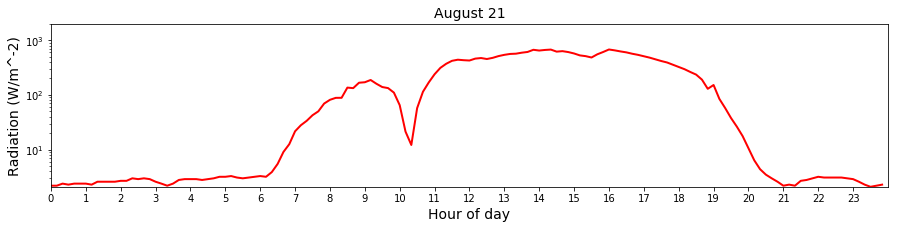

In [25]:
# Setting parameters for plotting
# rec_per_day = len(all_hr)*len(all_minutes_rec)
rec_per_hr = len(all_minutes_rec)
rec_idx = range(0,24*rec_per_hr,rec_per_hr)       # for solar radiation
rec_labels = [str(x) for x in range(24)]

# Plot solar radiation
fig,ax = plt.subplots(1,1,sharex=True,figsize=(15,3))
ax.plot(srad_data['SRAD1'][idx_subset],'r',linewidth=2)
ax.set_yscale('log')
ax.set_xticks(rec_idx)
ax.set_xticklabels(rec_labels)
ax.set_xlim([0,24*rec_per_hr])
ax.set_xlabel('Hour of day',fontsize=14)
ax.set_ylim([0,2E3])
ax.set_yscale('log')
ax.set_ylabel('Radiation (W/m^-2)',fontsize=14)
ax.set_title('August 21',fontsize=14)
plt.show()

This looks pretty sweet, since we see this nice "dip" around 10AM, which is when we saw the zooplankton making a sudden upward movement on the echogram above.

## Putting it all together

Now we can finally put everything all together: we will plot the variation of solar radiation level along with the echogram at 200 kHz to see how the zooplankton animals respond to the eclipse.

/Users/wu-jung/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


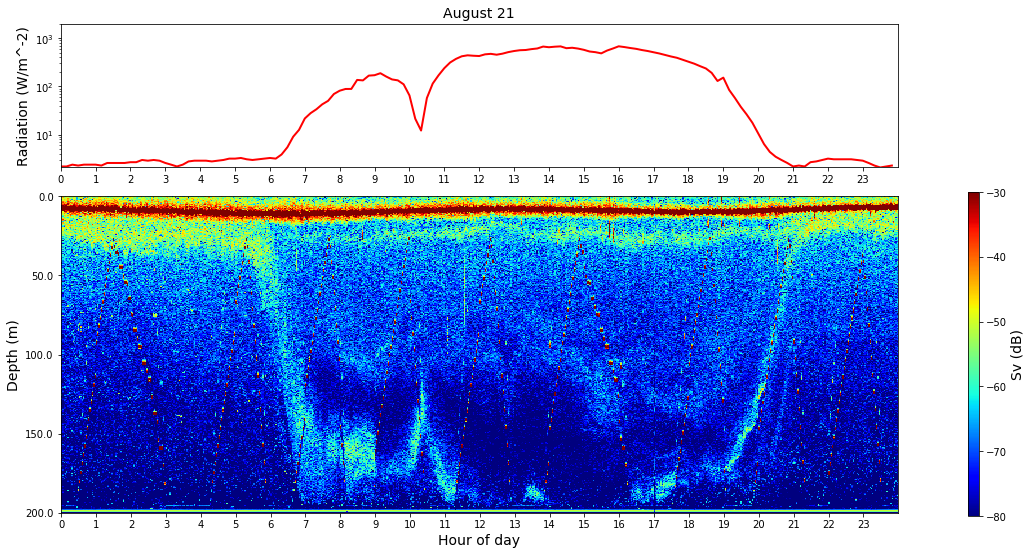

In [26]:
# fig,[ax0,ax2]
fig = plt.figure(figsize=(15,9))
ax0 = plt.subplot2grid((3, 1), (0, 0))
ax1 = plt.subplot2grid((3, 1), (1, 0),rowspan=2)

ax0.plot(srad_data['SRAD1'][idx_subset],'r',linewidth=2)
ax0.set_yscale('log')
ax0.set_xticks(rec_idx)
ax0.set_xticklabels(rec_labels)
ax0.set_xlim([0,24*rec_per_hr])
ax0.set_ylim([0,2E3])
ax0.set_yscale('log')
ax0.set_ylabel('Radiation (W/m^-2)',fontsize=14)
ax0.set_title('August 21',fontsize=14)

data_axes = edata_view.echogram(ax1,echopype_view.ECHOGRAM_PARAMS,freq)
ax1.set_ylabel('Depth (m)',fontsize = 14)
ax1.set_xlabel('Hour of day',fontsize = 14)
cax = fig.add_axes([0.965, 0.12, 0.01, 0.5])
cb = fig.colorbar(data_axes, cax=cax, use_gridspec=True)
cb.set_label('Sv (dB)',fontsize=14)

plt.show()